
# CONVEX HULL ANALYSIS

The goal is to evaluate the importance of leaving out old records present in our GBIF and OBIS Datasets of worldwide migratory and non-migratory fishes.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
import warnings; warnings.simplefilter('ignore')



In [3]:
fn2 = 'GBIF_OBIS_db.zip'
d = pd.read_csv(fn2, compression='zip', usecols=['sciname','Long','Lat','Year','database','AnaCat'])
gd = gpd.GeoDataFrame(d, geometry=gpd.points_from_xy(d.Long, d.Lat),crs = {'init': 'epsg:4326'})
del d

## Collection records statistical distribution

First of all, let's look at the quantile distribution of all records in the database. The first record dates back to 1643!

count    4.762113e+06
mean     1.995036e+03
std      1.736682e+01
min      1.643000e+03
25%      1.987000e+03
50%      1.999000e+03
75%      2.007000e+03
max      2.019000e+03
Name: Year, dtype: float64


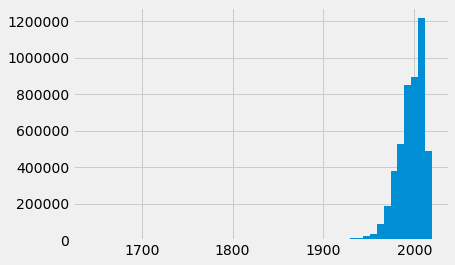

In [3]:
print(gd.Year.describe())

gd.Year.hist(bins=50)

Looking at these records, if we subset only those taken after 1900, we can see that most of them were taken around the second half of the 1990's, actually closer to the 2000's (i.e. mean=1995 and median=1999)

In [ ]:
print(gd[gd.Year >=1900].Year.describe())
gd[gd.Year >=1900].Year.hist(bins=50)

However, how do we know if we can trust records taken more than 100 yrs ago? To answer this, we needed to understand how much information is lost or shifted when we remove those older records. A possible test would be to look at whether and how new records extend the distribution range of species.  Looking at the distribution ranges of older records and evaluating how many new records fall beyond those ranges. Looking at potential solutions, we created an analysis based on indications given [here](https://gis.stackexchange.com/questions/294206/create-a-polygon-from-coordinates-in-geopandas-with-python).

Let's first look at the distibution of new records across time: 

In [6]:
tab = pd.DataFrame({'> 1960': [len(gd.loc[gd.Year >= 1960]), len(set(gd.loc[gd.Year >= 1960].sciname)), len(set(zip(gd.loc[gd.Year >= 1960].Long,gd.loc[gd.Year >= 1960].Lat)))],
                    '> 1970': [len(gd.loc[gd.Year >= 1970]), len(set(gd.loc[gd.Year >= 1970].sciname)), len(set(zip(gd.loc[gd.Year >= 1970].Long,gd.loc[gd.Year >= 1970].Lat)))],
                    '> 1980': [len(gd.loc[gd.Year >= 1980]), len(set(gd.loc[gd.Year >= 1980].sciname)), len(set(zip(gd.loc[gd.Year >= 1980].Long,gd.loc[gd.Year >= 1980].Lat)))],
                    '> 1990': [len(gd.loc[gd.Year >= 1990]), len(set(gd.loc[gd.Year >= 1990].sciname)), len(set(zip(gd.loc[gd.Year >= 1990].Long,gd.loc[gd.Year >= 1990].Lat)))],
                    '> 2000': [len(gd.loc[gd.Year >= 2000]), len(set(gd.loc[gd.Year >= 2000].sciname)), len(set(zip(gd.loc[gd.Year >= 2000].Long,gd.loc[gd.Year >= 2000].Lat)))],
                    'AllRecs': [len(gd), len(set(gd.sciname)), len(set(zip(gd.Long,gd.Lat)))] },index=['Rec. Numbers','Unique Species','Unique Locations'] )

In [9]:
print (tab)

                   > 1960   > 1970   > 1980   > 1990   > 2000  AllRecs
Rec. Numbers      4633502  4486961  4105680  3370419  2261871  4843743
Unique Species       3578     3545     3446     3310     3113     3661
Unique Locations   928116   885331   798836   655783   427063  1009664


## Spatial distribution of records 
We chose the abitrary date of 1980 as a threshold year and seek to evaluate missed spatial distribution information 

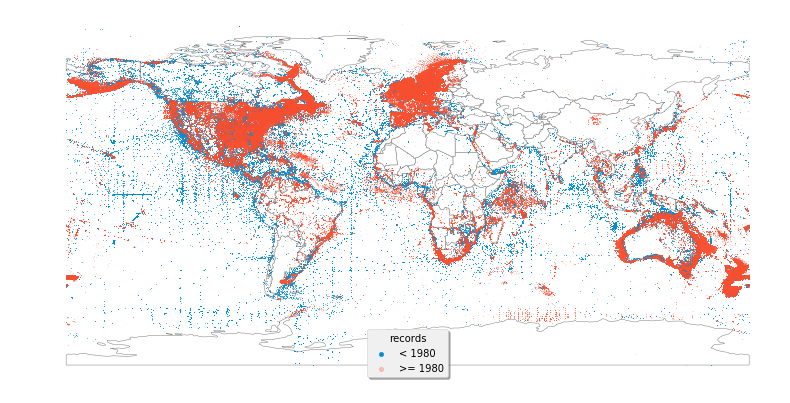

In [33]:
fig, ax = plt.subplots(figsize  = (12, 8))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='grey',ax=ax)
gd[gd.Year <  1980].plot(markersize=.1,ax=ax,label='< 1980',legend=True)
gd[gd.Year >= 1980].plot(markersize=.1,alpha=.3,ax=ax,label='>= 1980',legend=True)
#ax.set_title('records in OBIS database')
ax.set_axis_off()
legend = ax.legend(title="records", fancybox=True, shadow=True,markerscale=14)
plt.savefig('all_greens_R_old.png',dpi=300) # dpi's for publication quality figures


The map above shows a somewhat heterogeneous distribution of the sampling database on which our study is based. For instance, a large fraction of the South American Pacific coast is undersampled after 1980. Similar patterns are seen for the Horn of Africa, the coast of Nigeria, West Africa, and Melanesia. Inland data shows that newer records cover a good amount of the USA and Europe. However, most inland Canadian records in the OBIS and GBIF database were collected prior to 1980, a pattern that is not so evident for mainland Africa and South America, even though a low density of records are seen in these continents.

## Convex hull analysis
We developed a simple analysis to evaluate whether species increased their record collection after the chosen threshold year (1980), and whether they will change substantially their distribution ranges. The approach consists of evaluating the empirical probability of finding new records beyond the convex hull polygon of the range built with records collected up to the threshold year (i.e. 1980).

In [4]:
from shapely.geometry import Polygon, MultiPoint

def sp_range_analysis(species='Lethrinus erythropterus',yr_lim=1980,geodataf=gd, plotit=False):
    min_yr = yr_lim
    sp  = species
    ofn = 'range_analysis.csv'
    recs_ = gd[gd.sciname==species]
    pre_  = gd.loc[(gd.sciname==sp) & (gd.Year < min_yr)]
    post_ = gd[(gd.sciname==sp) & (gd.Year >= min_yr)]
    
    num_recs = len(recs_)
    num_prev = len(pre_)
    num_post = len(post_)
    
    lon_list = pre_.geometry.x
    lat_list = pre_.geometry.y
    mp = MultiPoint(list(zip(lon_list,lat_list)))
    conv_hull = mp.convex_hull
    poly = Polygon(conv_hull)

    dff = gpd.GeoDataFrame({'<yr':min_yr,'sciname':sp,'geometry': gpd.GeoSeries(poly)},crs = {'init': 'epsg:4326'})
    
    if plotit:
        fig, ax = plt.subplots(figsize  = (12, 8))
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        dff.plot(ax=ax,label=sp,legend=True,alpha = .1,color="green")
        base = world.plot(color='white', edgecolor='grey',ax=ax)
        pre_.plot(ax=ax,color='blue',label='<'+str(min_yr),legend=True,markersize=2)
        post_.plot(ax=ax,color='red',markersize=2,label='>='+str(min_yr))
        ax.set_axis_off()
        legend = ax.legend(title=sp, fancybox=True, shadow=True)
        plt.savefig('range_analysis/range_test_'+sp+'.png',dpi=300)
        
    out_recs = 0
    for i,r in post_.iterrows():
        a = dff.geometry.contains(r.geometry)
        #print (a.values)
        if a.values:
            out_recs = out_recs+1
    res = pd.DataFrame({
                        'sciname':sp,
                        'total_recs':num_recs,
                        'pre_'+str(min_yr):num_prev,
                        'post_'+str(min_yr):num_post,
                        'recs_out_poly':str(out_recs)
                       }, index=[0])
    return(res)


Finally, we need to generate a file with the results of the convex hull analysis

In [5]:
# Iterate over the list of all species
spp = list(set(gd.sciname))
min_yr = 1980
ofn='test_range_analysis.csv'

results = pd.DataFrame({
                        'sciname':None,
                        'total_recs':None,
                        'pre_'+str(min_yr):None,
                        'post_'+str(min_yr):None,
                        'recs_out_poly':None
                       }, index=[0])
results.to_csv(ofn,mode='a+',index=False,header=True)

for s in spp:
    try:
        results = sp_range_analysis(species=s,yr_lim=min_yr)
        results.to_csv(ofn,mode='a+',index=False,header=False)
    except:
        None

We can now count how many records were collected prior and after the threshold year and how many of those records fell outside of the convex hull polygon outlined by those records collected before the threshold year. This would give us an idea if and to which extent some species show a different distribution range when compared to older records. 

Results show that an average of 1357 species falls outside the range established by records collected before 1980. However, to get a better reflection of the probabiity distribution of those records we need to further our analysis, as done further below

In [6]:
ofn='test_range_analysis.csv'
range_data = pd.read_csv(ofn)
range_data.describe()

,sciname,total_recs,pre_1980,post_1980,recs_out_poly
count,5571,5571,5571,5571,5571
unique,2786,1144,616,999,907
top,Stolephorus holodon,11,3,0,0
freq,2,70,276,168,870


## Frequency distribution of the probability for species collected after 1980 to fall outside the species' old distribution range
To get a better feeling of how much the information on species' distribution data may have change over the years, we can plot the frequency distribution for records falling outside of the old species' range. This actually represents the actual probability of finding records outside the range outlines by 1990 for each species. Results basically tell us that approximately 200 species may fall outside the species old range with a probability between 80 and 100%, whereas approximately 700 species have less than 10% probability of being represented outside the species range delimited by records collected before 1980. 

In [7]:
plt.hist(range_data.recs_out_poly/(range_data.total_recs))
plt.title('OBIS and GBIF records outside species\' convex hull polygon of 1980')
plt.xlabel('probability')
plt.ylabel('frequency')
#plt.savefig('convex_hull_range_analysis.png',dpi=300)

TypeError: unsupported operand type(s) for /: 'str' and 'str'